<a href="https://colab.research.google.com/github/laurent-19/cyber_security_iov/blob/main/Multi_output_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# File paths
files = [
    'decimal_benign.csv',
    'decimal_DoS.csv',
    'decimal_spoofing-GAS.csv',
    'decimal_spoofing-RPM.csv',
    'decimal_spoofing-SPEED.csv',
    'decimal_spoofing-STEERING_WHEEL.csv'
]

# Split each dataframe into training and validation sets
train_dataframes = []
val_dataframes = []

for file in files:
    df = pd.read_csv(file)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_dataframes.append(train_df)
    val_dataframes.append(val_df)

# Combine the training and validation DataFrames separately
train_data = pd.concat(train_dataframes, ignore_index=True)
val_data = pd.concat(val_dataframes, ignore_index=True)

# Convert ID and DATA columns to numeric
for col in ['ID'] + [f'DATA_{i}' for i in range(8)]:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    val_data[col] = pd.to_numeric(val_data[col], errors='coerce')

# Drop rows with NaN values in any field
train_data.dropna(inplace=True)
val_data.dropna(inplace=True)

# Define categories and specific classes
categories = ['BENIGN', 'DoS', 'SPOOFING']
specific_classes = ['BENIGN', 'SPEED', 'DoS', 'GAS', 'RPM', 'STEERING_WHEEL']

# Encode categorical features for training data
label_encoder = LabelEncoder()
category_encoder = LabelEncoder()
specific_class_encoder = LabelEncoder()

train_data['label'] = label_encoder.fit_transform(train_data['label'])
train_data['category'] = category_encoder.fit_transform(train_data['category'])
train_data['specific_class'] = specific_class_encoder.fit_transform(train_data['specific_class'])

# Encode categorical features for validation data
val_data['label'] = label_encoder.transform(val_data['label'])
val_data['category'] = category_encoder.transform(val_data['category'])
val_data['specific_class'] = specific_class_encoder.transform(val_data['specific_class'])

# Define feature columns and labels
feature_columns = ['ID'] + [f'DATA_{i}' for i in range(8)]
label_columns = ['label', 'category', 'specific_class']

# Normalize the feature columns
train_data[feature_columns] = train_data[feature_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
val_data[feature_columns] = val_data[feature_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Create a PyTorch Dataset
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, feature_columns, label_columns):
        self.features = dataframe[feature_columns].values
        self.labels = dataframe[label_columns].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, labels

# Create the datasets and dataloaders
train_dataset = MultiLabelDataset(train_data, feature_columns, label_columns)
val_dataset = MultiLabelDataset(val_data, feature_columns, label_columns)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the multi-output model
class MultiOutputNN(nn.Module):
    def __init__(self, input_size, num_classes1, num_classes2, num_classes3):
        super(MultiOutputNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)

        # Output layers for each of the three tasks
        self.output1 = nn.Linear(64, num_classes1)  # For label
        self.output2 = nn.Linear(64, num_classes2)  # For category
        self.output3 = nn.Linear(64, num_classes3)  # For specific_class

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        out1 = self.output1(x)
        out2 = self.output2(x)
        out3 = self.output3(x)

        return out1, out2, out3

# Initialize the model, loss functions, and optimizer
input_size = len(feature_columns)
num_classes_label = len(label_encoder.classes_)
num_classes_category = len(category_encoder.classes_)
num_classes_specific_class = len(specific_class_encoder.classes_)

model = MultiOutputNN(input_size, num_classes_label, num_classes_category, num_classes_specific_class)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to compute metrics
def compute_metrics(labels, preds, num_classes):
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, labels=range(num_classes))
    return accuracy, precision, recall, f1

In [58]:
# Train the Model
num_epochs = 10
losses = []
val_losses = []
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_label_preds = []
    all_category_preds = []
    all_specific_class_preds = []
    all_label_labels = []
    all_category_labels = []
    all_specific_class_labels = []

    for features, labels in train_loader:
        label_out, category_out, specific_class_out = model(features)

        label_loss = criterion(label_out, labels[:, 0])
        category_loss = criterion(category_out, labels[:, 1])
        specific_class_loss = criterion(specific_class_out, labels[:, 2])
        loss = label_loss + category_loss + specific_class_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Store predictions and labels for metric computation
        _, label_preds = torch.max(label_out, 1)
        _, category_preds = torch.max(category_out, 1)
        _, specific_class_preds = torch.max(specific_class_out, 1)

        all_label_preds.extend(label_preds.cpu().numpy())
        all_category_preds.extend(category_preds.cpu().numpy())
        all_specific_class_preds.extend(specific_class_preds.cpu().numpy())

        all_label_labels.extend(labels[:, 0].cpu().numpy())
        all_category_labels.extend(labels[:, 1].cpu().numpy())
        all_specific_class_labels.extend(labels[:, 2].cpu().numpy())

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}')

    # Validation
    model.eval()
    val_epoch_loss = 0
    val_label_preds = []
    val_category_preds = []
    val_specific_class_preds = []
    val_label_labels = []
    val_category_labels = []
    val_specific_class_labels = []

    with torch.no_grad():
        for features, labels in val_loader:
            label_out, category_out, specific_class_out = model(features)

            label_loss = criterion(label_out, labels[:, 0])
            category_loss = criterion(category_out, labels[:, 1])
            specific_class_loss = criterion(specific_class_out, labels[:, 2])
            loss = label_loss + category_loss + specific_class_loss
            val_epoch_loss += loss.item()

            # Store predictions and labels for metric computation
            _, label_preds = torch.max(label_out, 1)
            _, category_preds = torch.max(category_out, 1)
            _, specific_class_preds = torch.max(specific_class_out, 1)

            val_label_preds.extend(label_preds.cpu().numpy())
            val_category_preds.extend(category_preds.cpu().numpy())
            val_specific_class_preds.extend(specific_class_preds.cpu().numpy())

            val_label_labels.extend(labels[:, 0].cpu().numpy())
            val_category_labels.extend(labels[:, 1].cpu().numpy())
            val_specific_class_labels.extend(labels[:, 2].cpu().numpy())

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss}')

    # Save the model if the validation loss improves
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'iov_model_best.pth')
        print(f"Model saved with validation loss {best_loss}")

    # Compute metrics
    train_accuracy_label, train_precision_label, train_recall_label, train_f1_label = compute_metrics(all_label_labels, all_label_preds, num_classes_label)
    val_accuracy_label, val_precision_label, val_recall_label, val_f1_label = compute_metrics(val_label_labels, val_label_preds, num_classes_label)

    train_accuracy_category, train_precision_category, train_recall_category, train_f1_category = compute_metrics(all_category_labels, all_category_preds, num_classes_category)
    val_accuracy_category, val_precision_category, val_recall_category, val_f1_category = compute_metrics(val_category_labels, val_category_preds, num_classes_category)

    train_accuracy_specific_class, train_precision_specific_class, train_recall_specific_class, train_f1_specific_class = compute_metrics(all_specific_class_labels, all_specific_class_preds, num_classes_specific_class)
    val_accuracy_specific_class, val_precision_specific_class, val_recall_specific_class, val_f1_specific_class = compute_metrics(val_specific_class_labels, val_specific_class_preds, num_classes_specific_class)

    print(f"Training Label Accuracy: {train_accuracy_label}")
    for i in range(num_classes_label):
        print(f"Class {i} - Label: Training Precision: {train_precision_label[i]}, Recall: {train_recall_label[i]}, F1-Score: {train_f1_label[i]}")

    print(f"Validation Label Accuracy: {val_accuracy_label}")
    for i in range(num_classes_label):
        print(f"Class {i} - Label: Validation Precision: {val_precision_label[i]}, Recall: {val_recall_label[i]}, F1-Score: {val_f1_label[i]}")

    print(f"Training Category Accuracy: {train_accuracy_category}")
    for i in range(num_classes_category):
        print(f"Class {i} - Category: Training Precision: {train_precision_category[i]}, Recall: {train_recall_category[i]}, F1-Score: {train_f1_category[i]}")

    print(f"Validation Category Accuracy: {val_accuracy_category}")
    for i in range(num_classes_category):
        print(f"Class {i} - Category: Validation Precision: {val_precision_category[i]}, Recall: {val_recall_category[i]}, F1-Score: {val_f1_category[i]}")

    print(f"Training Specific Class Accuracy: {train_accuracy_specific_class}")
    for i in range(num_classes_specific_class):
        print(f"Class {i} - Specific Class: Training Precision: {train_precision_specific_class[i]}, Recall: {train_recall_specific_class[i]}, F1-Score: {train_f1_specific_class[i]}")

    print(f"Validation Specific Class Accuracy: {val_accuracy_specific_class}")
    for i in range(num_classes_specific_class):
        print(f"Class {i} - Specific Class: Validation Precision: {val_precision_specific_class[i]}, Recall: {val_recall_specific_class[i]}, F1-Score: {val_f1_specific_class[i]}")


Epoch 1/10, Training Loss: 0.00017628340648573088
Epoch 1/10, Validation Loss: 6.755799017441958e-05
Model saved with validation loss 6.755799017441958e-05
Training Label Accuracy: 0.9999832317826557
Class 0 - Label: Training Precision: 0.9999415986398972, Recall: 0.9999351100209595, F1-Score: 0.9999383543199021
Class 1 - Label: Training Precision: 0.9999897853910663, Recall: 0.9999908068425692, F1-Score: 0.999990296116557
Validation Label Accuracy: 1.0
Class 0 - Label: Validation Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Class 1 - Label: Validation Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Training Category Accuracy: 0.9999788190938809
Class 0 - Category: Training Precision: 0.9999908068331788, Recall: 0.9999897853806324, F1-Score: 0.9999902961066447
Class 1 - Category: Training Precision: 0.999933035340599, Recall: 0.9999832579943078, F1-Score: 0.9999581460368482
Class 2 - Category: Training Precision: 0.9998834437086093, Recall: 0.9998622545747375, F1-Score: 0.9998728490294143
Val

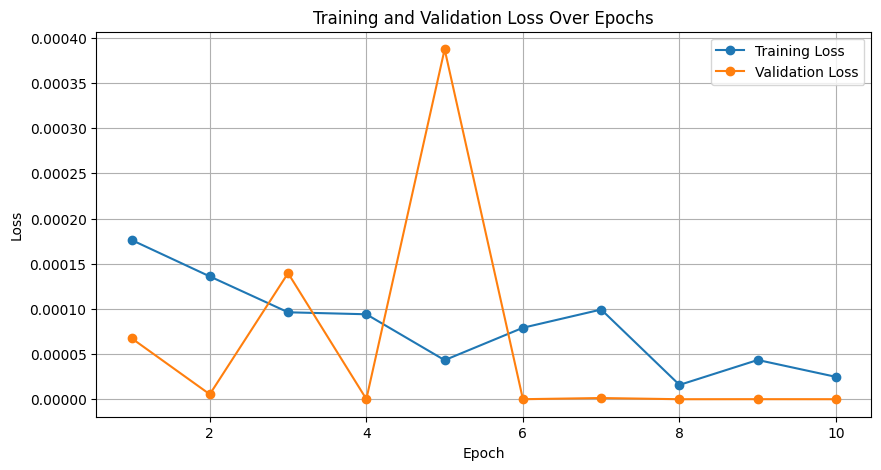

In [60]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()